In [445]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import glob
import numpy_financial as npf
from scipy import optimize

In [446]:
# YY-MM-DD
# CSV should have Date and Close columns
start_date = '2016-01-01'
# end_date = '2019-05-01'
end_date = datetime.now().strftime('%Y-%m-%d')
file_paths = glob.glob('RunTemp/*.csv')

# CODE

## Yearly Returns

In [447]:
def calculate_yearly_returns(file_path):
    data = pd.read_csv(file_path)
    # Convert the 'Date' column to datetime
    try:
        data['Date'] = pd.to_datetime(data['Date'],format='%d %b %Y')
    except:
        data['Date'] = pd.to_datetime(data['Date'],format='%d-%b-%y')

    data = data.sort_values('Date', ascending=True)
    data['Year'] = data['Date'].dt.year
    # Take data only from Month and year of start_date
    data = data[data['Date'] >= start_date]
    yearly_data = data.groupby('Year')['Close'].agg(['first', 'last']).reset_index()
    yearly_data['Yearly Return'] = ((yearly_data['last'] - yearly_data['first']) / yearly_data['first']) * 100
    return yearly_data[['Year', 'Yearly Return']]


returns_data = {}

for file_path in file_paths:
    index_name = file_path.split('/')[-1].split('.')[0].split('\\')[1]  # Extract index name from file name
    yearly_returns = calculate_yearly_returns(file_path)
    returns_data[index_name] = yearly_returns.set_index('Year')['Yearly Return']
yearly_returns_df = pd.DataFrame(returns_data)

### Average Yearly Returns

In [448]:
# average_returns.plot.bar(figsize=(14, 7))
# plt.ylabel('Return (%)', fontsize=12)
# plt.title('Average Yearly Returns', fontsize=15)
# plt.xticks(rotation=45)
# plt.yticks(range(-10, 100, 5))
# plt.grid(True)
# plt.show()
# print(average_returns.sort_values(ascending=False))

### Yearly Returns Heatmap

In [449]:
ranked_returns = yearly_returns_df.rank(axis=1, ascending=False)
ranked_returns = ranked_returns.T

## CAGR Returns

In [450]:
def calculate_cagr_returns(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    # Convert the 'Date' column to datetime
    try:
        data['Date'] = pd.to_datetime(data['Date'],format='%d %b %Y')
    except:
        data['Date'] = pd.to_datetime(data['Date'],format='%d-%b-%y')
    
    # Sort the data by date
    data = data[data['Date'] >= start_date]
    data = data[data['Date'] <= end_date]
    
    data = data.sort_values('Date', ascending=True)
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]
    years = (data['Date'].iloc[-1] - data['Date'].iloc[0]).days/365
    cagr = ((end_price/start_price)**(1/years))-1
    cagr = cagr*100
    return cagr

returns_data = {}
for file_path in file_paths:
    index_name = file_path.split('/')[-1].split('.')[0].split('\\')[1]
    returns_data[index_name] = calculate_cagr_returns(file_path)

cagr_df = pd.DataFrame(returns_data.items(), columns=['Index', 'CAGR'])
cagr_df = cagr_df.set_index('Index')

### Lumpsum Absolute Returns

In [451]:
def calculate_absolute_returns(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    # Convert the 'Date' column to datetime
    try:
        data['Date'] = pd.to_datetime(data['Date'],format='%d %b %Y')
    except:
        data['Date'] = pd.to_datetime(data['Date'],format='%d-%b-%y')
    
    # Sort the data by date
    data = data[data['Date'] >= start_date]
    data = data[data['Date'] <= end_date]
    
    data = data.sort_values('Date', ascending=True)
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]
    absolute_returns = (end_price - start_price)/start_price*100
    return absolute_returns

returns_data = {}
for file_path in file_paths:
    index_name = file_path.split('/')[-1].split('.')[0].split('\\')[1]
    returns_data[index_name] = calculate_absolute_returns(file_path)

absolute_df = pd.DataFrame(returns_data.items(), columns=['Index', 'Lumpsum_Absolute_Returns'])
absolute_df = absolute_df.set_index('Index')

## SIP XIRR Returns

In [452]:
def xnpv(rate,cashflows):
    chron_order = sorted(cashflows, key = lambda x: x[0])
    t0 = chron_order[0][0]
    return sum([cf/(1+rate)**((t-t0).days/365.0) for (t,cf) in chron_order])

def xirr(cashflows,guess=0.1):
    return optimize.newton(lambda r: xnpv(r,cashflows),guess)

def calculate_sip_xirr(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    
    # Convert the 'Date' column to datetime
    try:
        data['Date'] = pd.to_datetime(data['Date'], format='%d %b %Y')
    except:
        data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
    
    # Filter data based on start and end dates if provided
    data = data[data['Date'] >= pd.to_datetime(start_date)]
    data = data[data['Date'] <= pd.to_datetime(end_date)]
    
    # Group by year and month and take the last available data point for each month
    data = data.groupby([data['Date'].dt.year, data['Date'].dt.month]).tail(1)
    data = data.sort_values('Date', ascending=True)
    
    # Initialize lists to store cash flows and their corresponding dates
    cash_flows = []
    dates = []
    
    # Iterate over each row and record the SIP investments
    for index, row in data.iterrows():
        cash_flows.append(-1000)  # SIP investment is negative cash flow
        dates.append(row['Date'])
    
    # Add the final value as a positive cash flow
    total_units = sum(1000 / row['Close'] for index, row in data.iterrows())
    final_value = total_units * data['Close'].iloc[-1]
    cash_flows.append(final_value)
    dates.append(data['Date'].iloc[-1])
    
    # Calculate XIRR
    sip_xirr = xirr(list(zip(dates, cash_flows)))
    
    return sip_xirr*100

returns_data = {}
for file_path in file_paths:
    index_name = file_path.split('/')[-1].split('.')[0].split('\\')[1]
    returns_data[index_name] = calculate_sip_xirr(file_path)

sip_XIRR = pd.DataFrame(returns_data.items(), columns=['Index', 'SIP_XIRR'])
sip_XIRR = sip_XIRR.set_index('Index')

###  SIP Absolute Returns

In [453]:
def calculate_sip_absolute_returns(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    # Convert the 'Date' column to datetime
    try:
        data['Date'] = pd.to_datetime(data['Date'],format='%d %b %Y')
    except:
        data['Date'] = pd.to_datetime(data['Date'],format='%d-%b-%y')
    
    # Sort the data by date
    data = data[data['Date'] >= start_date]
    data = data[data['Date'] <= end_date]
    data = data.groupby([data['Date'].dt.year, data['Date'].dt.month]).tail(1)
    data = data.sort_values('Date', ascending=True)

    # iterate over each row and calculate the SIP returns
    total_investment = 0
    total_units = 0
    for index, row in data.iterrows():
        close_price = row['Close']
        total_investment += 1000
        units_purchased = 1000/close_price
        total_units += units_purchased
    
    final_value = total_units * data['Close'].iloc[-1]
    sip_returns = (final_value - total_investment)/total_investment*100
    return sip_returns

returns_data = {}
for file_path in file_paths:
    index_name = file_path.split('/')[-1].split('.')[0].split('\\')[1]
    returns_data[index_name] = calculate_sip_absolute_returns(file_path)

sip_absolute_df = pd.DataFrame(returns_data.items(), columns=['Index', 'SIP_Absolute_Returns'])
sip_absolute_df = sip_absolute_df.set_index('Index')

# Results

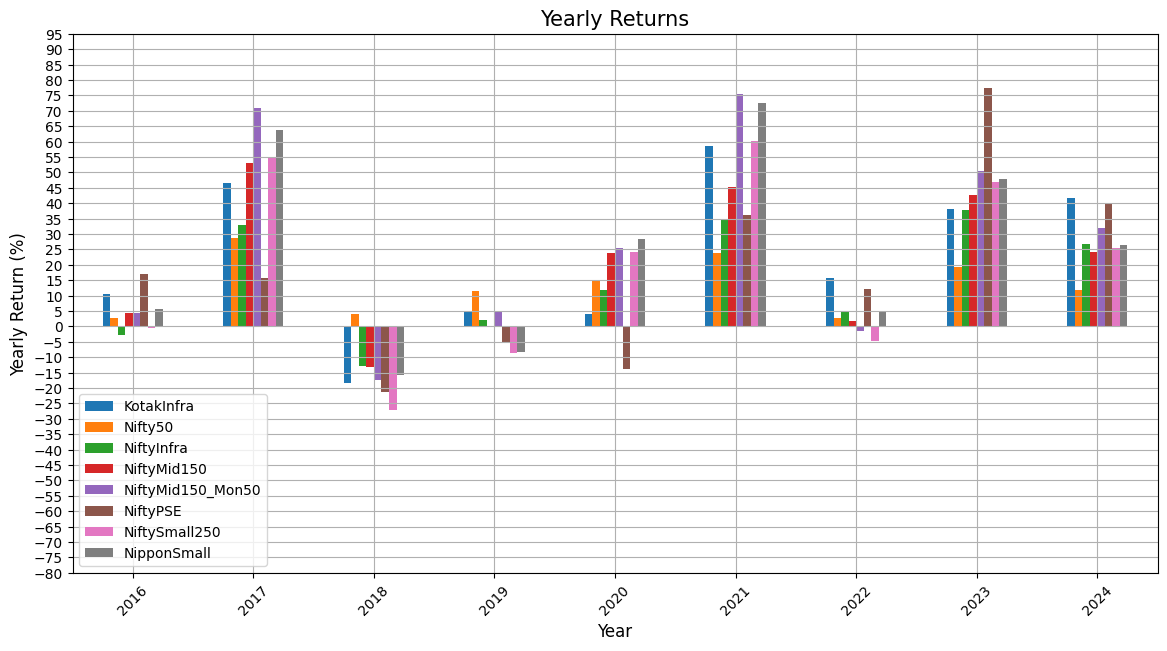

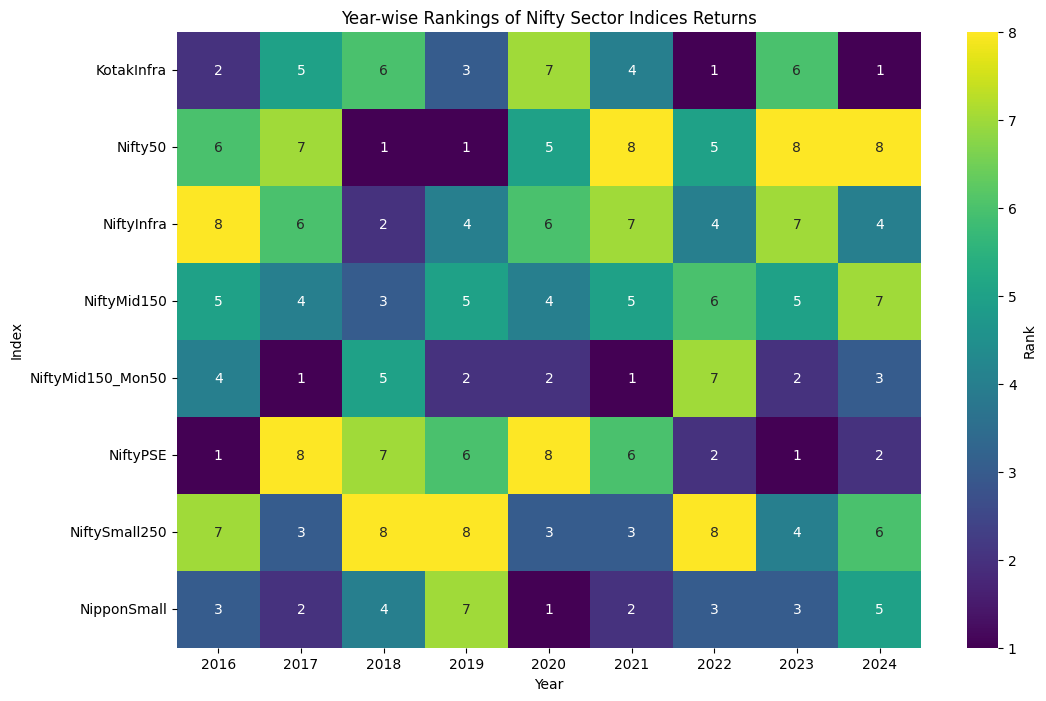

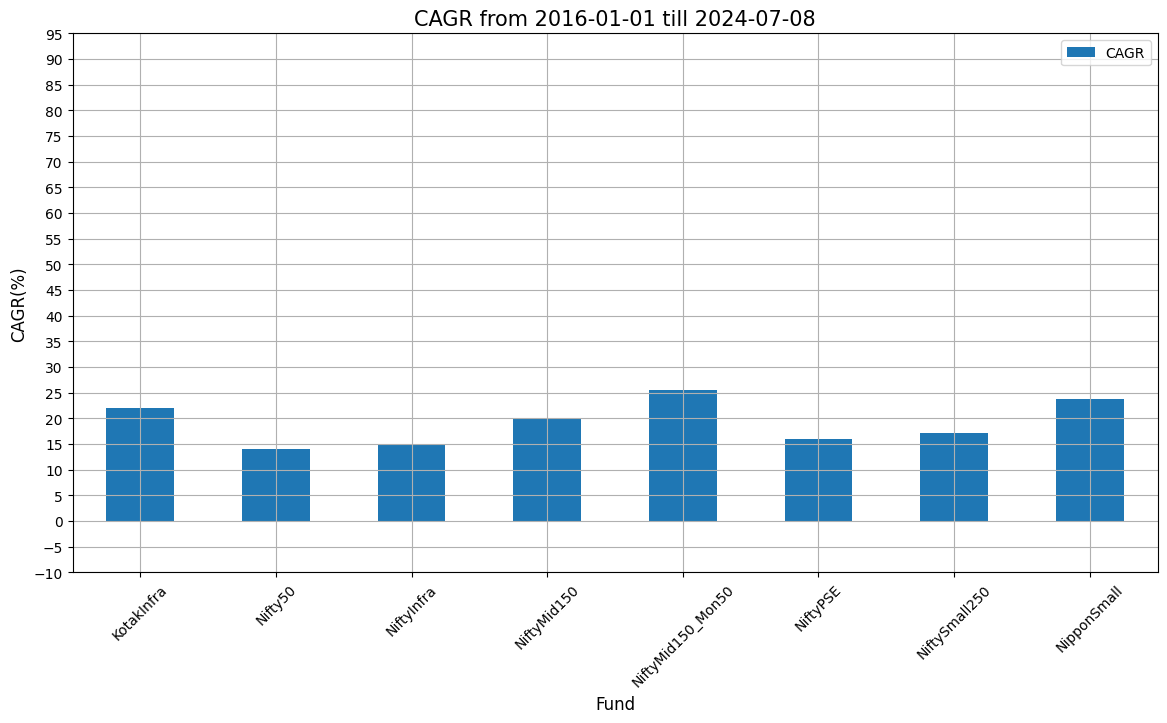



                        CAGR
Index                       
NiftyMid150_Mon50  25.603540
NipponSmall        23.791112
KotakInfra         21.937192
NiftyMid150        19.936247
NiftySmall250      17.088031
NiftyPSE           15.931502
NiftyInfra         15.101437
Nifty50            14.012208


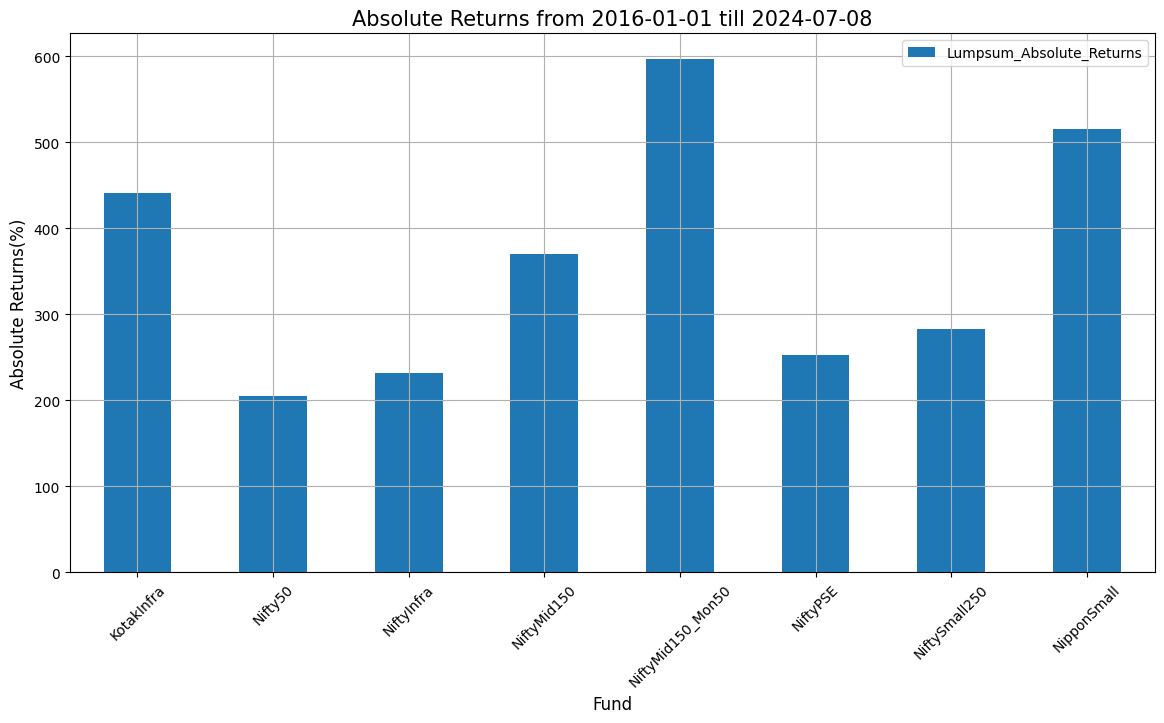



                   Lumpsum_Absolute_Returns
Index                                      
NiftyMid150_Mon50                596.639014
NipponSmall                      515.541211
KotakInfra                       441.321835
NiftyMid150                      370.184749
NiftySmall250                    283.167482
NiftyPSE                         252.111201
NiftyInfra                       231.212517
Nifty50                          205.453210


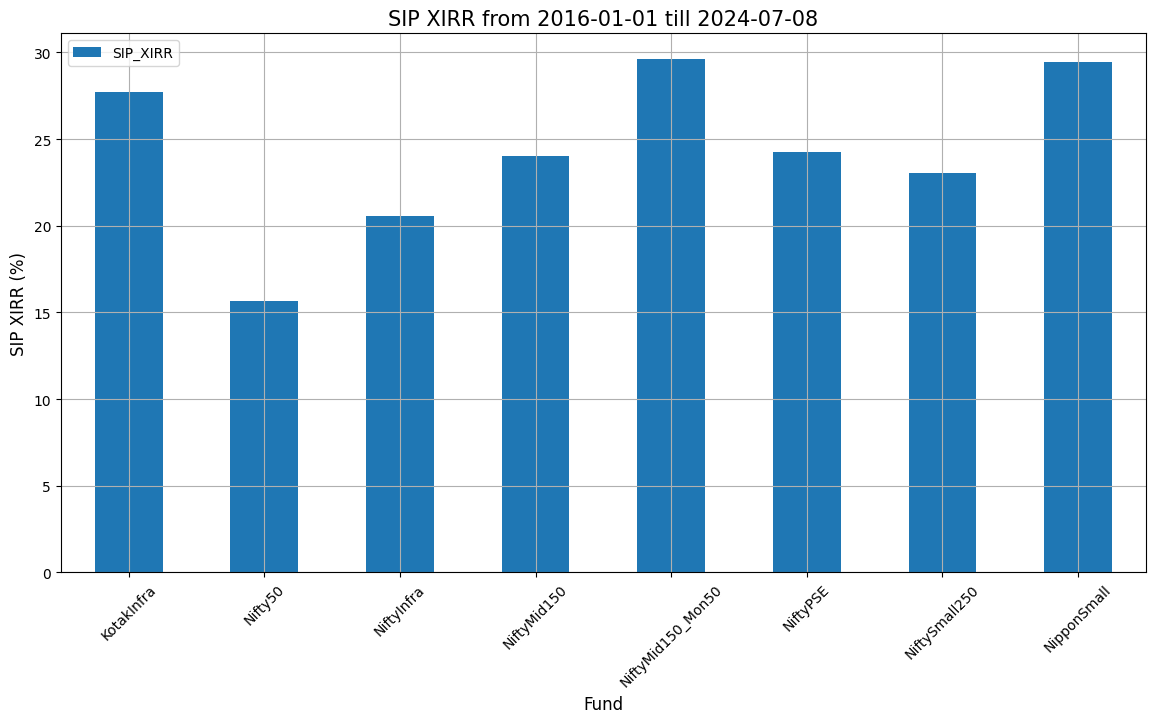



                    SIP_XIRR
Index                       
NiftyMid150_Mon50  29.618079
NipponSmall        29.466093
KotakInfra         27.745222
NiftyPSE           24.259776
NiftyMid150        24.003337
NiftySmall250      23.071732
NiftyInfra         20.575301
Nifty50            15.646297


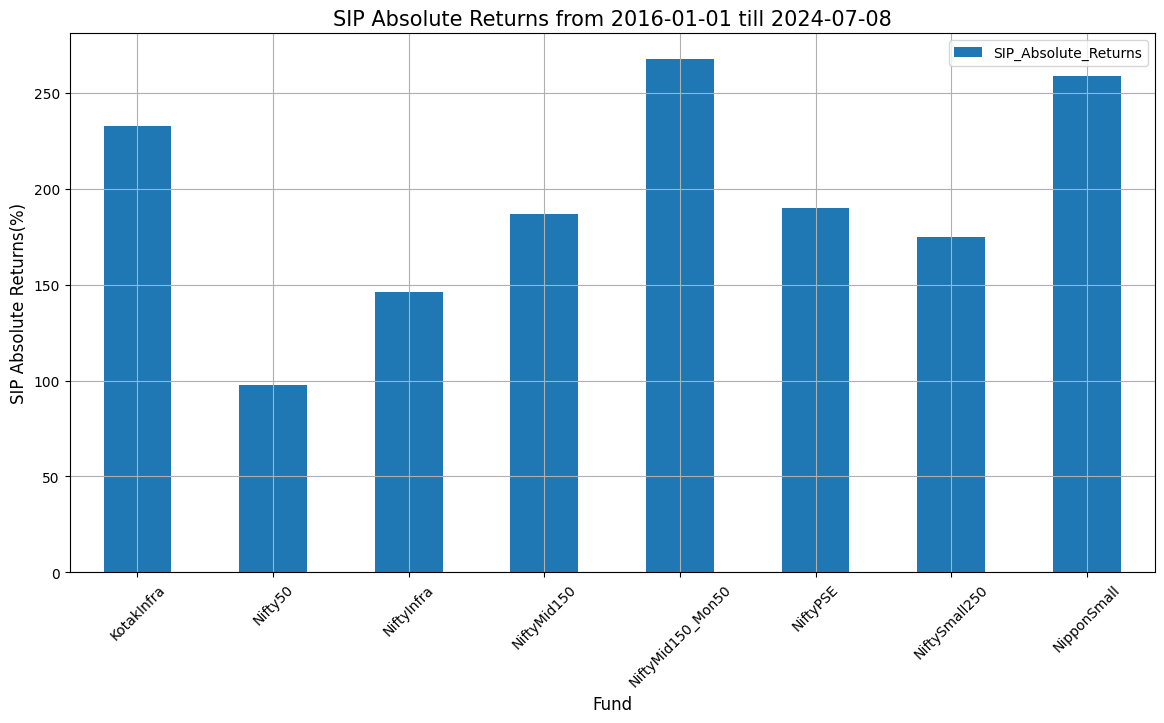



                   SIP_Absolute_Returns
Index                                  
NiftyMid150_Mon50            267.524658
NipponSmall                  258.830245
KotakInfra                   232.827966
NiftyPSE                     189.873870
NiftyMid150                  186.593652
NiftySmall250                174.983828
NiftyInfra                   146.130363
Nifty50                       97.788731


In [454]:
### Yearly Returns Barchart
yearly_returns_df.plot.bar(figsize=(14, 7))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yearly Return (%)', fontsize=12)
plt.title('Yearly Returns', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(range(-80, 100, 5))
plt.grid(True)
plt.show()

# Yearly Returns Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ranked_returns, annot=True, cmap='viridis', cbar_kws={'label': 'Rank'})
plt.title('Year-wise Rankings of Nifty Sector Indices Returns')
plt.xlabel('Year')
plt.ylabel('Index')
plt.show()

### CAGR Barchart
cagr_df.plot.bar(figsize=(14, 7))
plt.xlabel('Fund', fontsize=12)
plt.ylabel('CAGR(%)', fontsize=12)
plt.title(f'CAGR from {start_date} till {end_date}', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(range(-10, 100, 5))
plt.grid(True)
plt.show()
print("\n")
print(cagr_df.sort_values('CAGR', ascending=False))


### Lumpsum Absolute Returns Barchart
absolute_df.plot.bar(figsize=(14, 7))
plt.xlabel('Fund', fontsize=12)
plt.ylabel('Absolute Returns(%)', fontsize=12)
plt.title(f'Absolute Returns from {start_date} till {end_date}', fontsize=15)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
print("\n")
print(absolute_df.sort_values('Lumpsum_Absolute_Returns', ascending=False))

### SIP XIRR Barchart
sip_XIRR.plot.bar(figsize=(14, 7))
plt.xlabel('Fund', fontsize=12)
plt.ylabel('SIP XIRR (%)', fontsize=12)
plt.title(f'SIP XIRR from {start_date} till {end_date}', fontsize=15)
plt.xticks(rotation=45)
# plt.yticks(range(-50, 800, 50))
plt.grid(True)
plt.show()
print("\n")
print(sip_XIRR.sort_values('SIP_XIRR', ascending=False))


### SIP Absolute Returns Barchart
sip_absolute_df.plot.bar(figsize=(14, 7))
plt.xlabel('Fund', fontsize=12)
plt.ylabel('SIP Absolute Returns(%)', fontsize=12)
plt.title(f'SIP Absolute Returns from {start_date} till {end_date}', fontsize=15)
plt.xticks(rotation=45)
# plt.yticks(range(-50, 800, 50))
plt.grid(True)
plt.show()
print("\n")
print(sip_absolute_df.sort_values('SIP_Absolute_Returns', ascending=False))